# Integrating Product Design and Supply Chain Design

## Import Packages

In [158]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc;

## Parameters

In [159]:
numAssemblyOptions = 2
numSuppliersPerPart = 2

In [160]:
numEchelsons = 1
numComponents = 2

components = list(range(1, numComponents + 1))
componentsForSubsystems = {}
subsystemsForComponents = {}
if numEchelsons == 1:
    assembliesStructure = {n : [] for n in components}
    assemblyNodes = []
    finalNodes = [numComponents + 1]
else:
    assembliesStructure = {}
    assemblyNodes = list(assembliesStructure.keys())
allNodes = components + assemblyNodes + finalNodes
nonComponentNodes = assemblyNodes + finalNodes
print(components)
print(allNodes)

[1, 2]
[1, 2, 3]


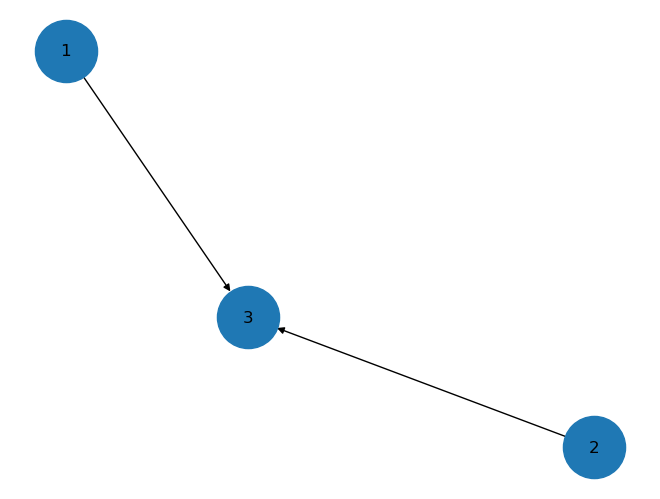

In [161]:
G = nx.DiGraph()

numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

np.random.seed(0)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for n in allNodes:
    time = np.random.randint(1, 4)
    if n in finalNodes:
        maxTime = 0
    else:
        maxTime = 100
    G.add_node(n, process_time=time, 
               max_service_time_out=maxTime,
               stage_cost=np.random.randint(1, 6))

# for n in assemblyNodes:
#     for component in assembliesStructure[n]:
#         G.add_edge(component, n)

if numEchelsons == 1:
    for n in components:
        for n2 in finalNodes:
            G.add_edge(n, n2)

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(G, 'process_time')
stageCostDict = nx.get_node_attributes(G, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

nx.draw(G, with_labels=True, node_size=2000)
plt.show()

In [162]:
safetyFactor = 1.645
sigma = 3
holdingCostRate = 0.2

In [163]:
def getMaxReplenishmentTime(n : int):
    if n in components:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(i) for i in G.predecessors(n)])
    
def getCumCost(n : int):
    if n in components:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(i) for i in G.predecessors(n)])

maxReplenishmentTime = {n : getMaxReplenishmentTime(n) for n in allNodes}
cumCost = {n : getCumCost(n) for n in allNodes}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df.to_csv('instance.csv')
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,1,100,1
1,2,2,4,4,100,2
2,3,2,3,8,0,4


This is a problem instance in which nodes 1 and 2 take different shortest paths to the sink.
    
,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,1,100,1
1,2,2,4,4,100,2
2,3,2,3,8,0,4

In [164]:

def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn(node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if node in finalNodes:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal + 1)

def get_sOut_range(node : int, sIn : int = 0):
    return range(sIn + processTimesDict[node]+ 1)

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def create_dp_graph(G : nx.DiGraph, sourcePerComponent : bool = True):
    dp_G = nx.DiGraph()
    #dp_G.add_node('t')
    if not sourcePerComponent:
        dp_G.add_node('s')
    for n in finalNodes:
        for sIn in get_sIn_range_for_g_fn(n):
            nodeTupleIn = str(n) + "_" + str(sIn)
            dp_G.add_node(nodeTupleIn)
        for sOut in get_sOut_range_for_g_fn(n, 0):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            #dp_G.add_edge(nodeTupleOut, 't', time = 0, time_reduce = 0,
            #              cost = 0)
            for sIn in get_sIn_range_for_g_fn(n):
                nodeTupleIn2 = str(n) + "_" + str(sIn)
                dp_G.add_edge(nodeTupleIn2, nodeTupleOut, 
                              time = sOut - sIn,
                              time_reduce = 0,
                              cost = getHoldingCost(n, sIn, sOut))
    for n in components:
        sIn = 0
        nodeTupleIn = str(n) + "_" + str(sIn)
        dp_G.add_node(nodeTupleIn)
        #dp_G.add_edge('s', nodeTupleIn, time = 0, time_reduce = 0, cost = 0)
        for sOut in get_sOut_range(n):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                          time = sOut - sIn, 
                          time_reduce = sOut - (sIn + processTimesDict[n]),
                          cost = getHoldingCost(n, sIn, sOut))
            for finalNode in finalNodes:
                finalNodeTupleIn = str(finalNode) + "_" + str(sOut)
                dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, time_reduce = 0,
                              time = 0, cost = 0)
    return dp_G

In [165]:
def create_dp_graphMulticommodity(G : nx.DiGraph, sourcePerComponent : bool = True):
    dp_G = nx.MultiDiGraph()
    if not sourcePerComponent:
        dp_G.add_node('s')
    for n in finalNodes:
        for sIn in get_sIn_range_for_g_fn(n):
            nodeTupleIn = str(n) + "_" + str(sIn)
            dp_G.add_node(nodeTupleIn)
        for sOut in get_sOut_range_for_g_fn(n, 0):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            for sIn in get_sIn_range_for_g_fn(n):
                for component in components:
                    nodeTupleIn2 = str(n) + "_" + str(sIn)
                    dp_G.add_edge(nodeTupleIn2, nodeTupleOut,
                                commodity = component, 
                                time = sOut - sIn,
                                time_reduce = 0,
                                cost = getHoldingCost(n, sIn, sOut))
    for n in components:
        sIn = 0
        nodeTupleIn = str(n) + "_" + str(sIn)
        dp_G.add_node(nodeTupleIn)
        for sOut in get_sOut_range(n):
            nodeTupleOut = str(n) + "^" + str(sOut)
            dp_G.add_node(nodeTupleOut)
            #edgeTuple = (nodeTupleIn, nodeTupleOut, n)
            dp_G.add_edge(nodeTupleIn, nodeTupleOut,
                          commodity = n, 
                          time = sOut - sIn, 
                          time_reduce = sOut - (sIn + processTimesDict[n]),
                          cost = getHoldingCost(n, sIn, sOut))
            for finalNode in finalNodes:
                finalNodeTupleIn = str(finalNode) + "_" + str(sOut)
                #edgeTuple = (nodeTupleOut, finalNodeTupleIn, n)
                dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, time_reduce = 0, commodity = n,
                              time = 0, cost = 0)
    return dp_G

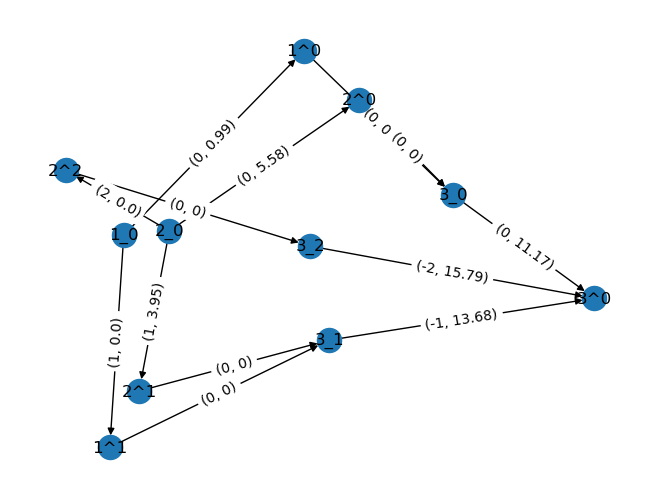

In [166]:
dp_G = create_dp_graph(G)

pos = nx.spring_layout(dp_G)
nx.draw(dp_G, pos, with_labels=True)
edge_labels = {(u, v): (data['time'], round(data['cost'],2)) 
               for u, v, data in dp_G.edges(data=True)}
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [167]:
edgesUsed = set()
for n in components:
    path = nx.shortest_path(dp_G, str(n) + '_0', '3^0', weight='cost')
    for i in range(len(path)-1):
        edgesUsed.add((path[i], path[i+1]))
    path_length = nx.shortest_path_length(dp_G, str(n) + '_0', '3^0', weight='cost')
    print("Cost", path_length)
    print("path", path)
print(edgesUsed)

Cost 12.153630288497961
path ['1_0', '1^0', '3_0', '3^0']
Cost 15.792000000000002
path ['2_0', '2^2', '3_2', '3^0']
{('1^0', '3_0'), ('1_0', '1^0'), ('3_2', '3^0'), ('2_0', '2^2'), ('2^2', '3_2'), ('3_0', '3^0')}


In [168]:
# dp_G_neg = dp_G.copy()
# for u, v, data in dp_G_neg.edges(data=True):
#     data['time'] = -data['time']

# pos = nx.kamada_kawai_layout(dp_G_neg)
# nx.draw(dp_G_neg, pos, with_labels=True)
# edge_labels_neg = {(u, v): (data['time'], round(data['cost'],1)) 
#                for u, v, data in dp_G_neg.edges(data=True)}
# nx.draw_networkx_edge_labels(dp_G_neg, pos, edge_labels=edge_labels_neg)
# plt.show()

In [169]:
# path = nx.shortest_path(dp_G_neg, 's', 't', weight='time')
# path_length = nx.shortest_path_length(dp_G_neg, 's', 't', weight='time')
# print("Total lead time", path_length)
# print("path", path)

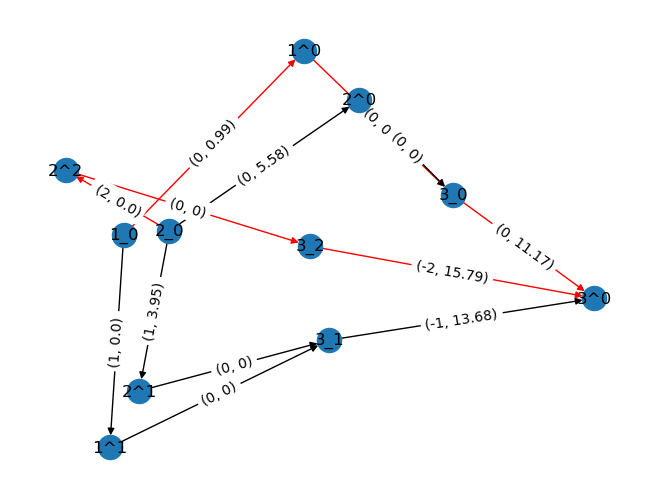

In [170]:
#edgesUsed = [(path[i], path[i+1]) for i in range(len(path)-1)]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [171]:
def getNetFlowExpr(G, x, node):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node))

def getNetFlowExprRHS(n):
    if n == '1_0' or n == '2_0':
        return 1
    elif n == '3^0':
        return -2
    else:
        return 0

In [172]:
def getOptimizedShortestPathModel(vtypeY = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log

    flowEdges = dp_G.edges() - dp_G.in_edges('3^0')

    x = m.addVars(dp_G.edges(), name="x")
    y = m.addVars(dp_G.in_edges('3^0'), name="y", vtype=vtypeY)
    m._x = x
    m._y = y

    m.setObjective(qsum(x[e]*dp_G.edges[e]['cost'] for e in flowEdges) + 
                qsum(y[e]*dp_G.edges[e]['cost'] for e in y), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= numComponents*y[e] for e in y), "UB")
    m.addConstrs((getNetFlowExpr(dp_G, x, n) == getNetFlowExprRHS(n) 
                for n in dp_G.nodes()), "netflow")

    m.optimize()
    return m

m = getOptimizedShortestPathModel(vtypeY = GRB.CONTINUOUS)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
m = getOptimizedShortestPathModel(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))

Relaxed Cost: $ 14.47
Optimal Cost: $ 17.62


In [173]:
print(dp_G.edges())
yCommodities = []
for e in dp_G.in_edges('3^0'):
    for c in components:
        yCommodities.append((e, c))
print(yCommodities)

[('3_0', '3^0'), ('3_1', '3^0'), ('3_2', '3^0'), ('1_0', '1^0'), ('1_0', '1^1'), ('1^0', '3_0'), ('1^1', '3_1'), ('2_0', '2^0'), ('2_0', '2^1'), ('2_0', '2^2'), ('2^0', '3_0'), ('2^1', '3_1'), ('2^2', '3_2')]
[(('3_0', '3^0'), 1), (('3_0', '3^0'), 2), (('3_1', '3^0'), 1), (('3_1', '3^0'), 2), (('3_2', '3^0'), 1), (('3_2', '3^0'), 2)]


In [174]:
dp_G_multicommod = create_dp_graphMulticommodity(G)
commodityEdges = [(e[0], e[1], e[2]['commodity']) for e in dp_G_multicommod.edges(data = True)]

def getCommodityInEdges(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.in_edges(node, data = True)]

def getCommodityOutEdges(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.out_edges(node, data = True)]

for n in dp_G_multicommod.nodes():  
    print(n, getCommodityInEdges(dp_G_multicommod, n))

3_0 [('1^0', '3_0', 1), ('2^0', '3_0', 2)]
3_1 [('1^1', '3_1', 1), ('2^1', '3_1', 2)]
3_2 [('2^2', '3_2', 2)]
3^0 [('3_0', '3^0', 1), ('3_0', '3^0', 2), ('3_1', '3^0', 1), ('3_1', '3^0', 2), ('3_2', '3^0', 1), ('3_2', '3^0', 2)]
1_0 []
1^0 [('1_0', '1^0', 1)]
1^1 [('1_0', '1^1', 1)]
2_0 []
2^0 [('2_0', '2^0', 2)]
2^1 [('2_0', '2^1', 2)]
2^2 [('2_0', '2^2', 2)]


In [175]:
def handleGurobiStatus(m : gp.Model):
    status = m.status
    if status == GRB.Status.INFEASIBLE:
        print("The model is infeasible. Computing IIS.")
        m.computeIIS()
        m.write('iismodel.ilp')
        sys.exit(0)
    elif status == GRB.Status.UNBOUNDED:
        print("The model is unbounded.")
        sys.exit(0)
    elif status == GRB.Status.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.Status.INF_OR_UNBD:  
        print("The model status is infeasible or unbounded. Set DualReductions parameter to 0 and reoptimize.")
        sys.exit(0)
    else:
        print("The model status is neither infeasible nor unbounded.")
        sys.exit(0)

In [176]:
def getNetFlowExpr(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdges(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node))
    return out_edges_sum - in_edges_sum

def getNetFlowExprWithCommod(G, x, node, commod):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdges(G, node) if e[2] == commod)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node) if e[2] == commod)
    return out_edges_sum - in_edges_sum

def getNetFlowExprRHS(n):
    if n == '1_0' or n == '2_0':
        return 1
    elif n == '3^0':
        return -1
    else:
        return 0

def getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log

    inEdges = getCommodityInEdges(dp_G_multicommod, '3^0')
    flowEdges = [item for item in commodityEdges if item not in inEdges]

    edgeCost = {(e[0], e[1], e[2]['commodity']) : e[2]['cost'] 
                for e in dp_G_multicommod.edges(data = True)}

    x = m.addVars(commodityEdges, name="x")
    y = m.addVars(getCommodityInEdges(dp_G_multicommod, '3^0'), name="y")
    z = m.addVars(dp_G.in_edges('3^0'), name="z", vtype=vtypeZ)
    m._x = x
    m._y = y
    m._z = z

    m.setObjective(qsum(edgeCost[e]*x[e] for e in flowEdges) + 
                qsum(z[e]*dp_G.edges[e]['cost'] for e in z), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= y[e] for e in y), "UB-y")
    m.addConstrs((y[e[0],e[1],c] <= z[e] for c in components for e in z), 
                 "UB-z")
    nodesWithCommod = ['3^0', '3_0', '3_1', '3_2']
    m.addConstrs((getNetFlowExpr(dp_G_multicommod, x, n) == getNetFlowExprRHS(n) 
                for n in dp_G.nodes() if n not in nodesWithCommod), "netflow")
    m.addConstrs((getNetFlowExprWithCommod(dp_G_multicommod, x, n, c) == getNetFlowExprRHS(n) 
                for n in nodesWithCommod for c in components), "netflow")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

m = getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
m = getOptimizedShortestPathModelMulticommodity(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

The model is optimal.
Relaxed Cost: $ 17.62
The model is optimal.
Optimal Cost: $ 17.62
x[3_0,3^0,1] 0
x[3_0,3^0,2] 0
x[3_1,3^0,1] 1
x[3_1,3^0,2] 1
x[3_2,3^0,1] 0
x[3_2,3^0,2] 0
x[1_0,1^0,1] 0
x[1_0,1^1,1] 1
x[1^0,3_0,1] 0
x[1^1,3_1,1] 1
x[2_0,2^0,2] 0
x[2_0,2^1,2] 1
x[2_0,2^2,2] 0
x[2^0,3_0,2] 0
x[2^1,3_1,2] 1
x[2^2,3_2,2] 0
y[3_0,3^0,1] 0
y[3_0,3^0,2] 0
y[3_1,3^0,1] 1
y[3_1,3^0,2] 1
y[3_2,3^0,1] 0
y[3_2,3^0,2] 0
z[3_0,3^0] 0
z[3_1,3^0] 1
z[3_2,3^0] -0


In [177]:
xVals = [m._x[e].x for e in dp_G.edges() if m._x[e].x > 0.0]
edgesUsed = [e for e in dp_G.edges() if m._x[e].x > 0.0]
costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'X': xVals,
    #'Time': times,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
#print("Cost: $", format(m.ObjVal, ",.2f"))
print(df)

KeyError: ('3_0', '3^0')

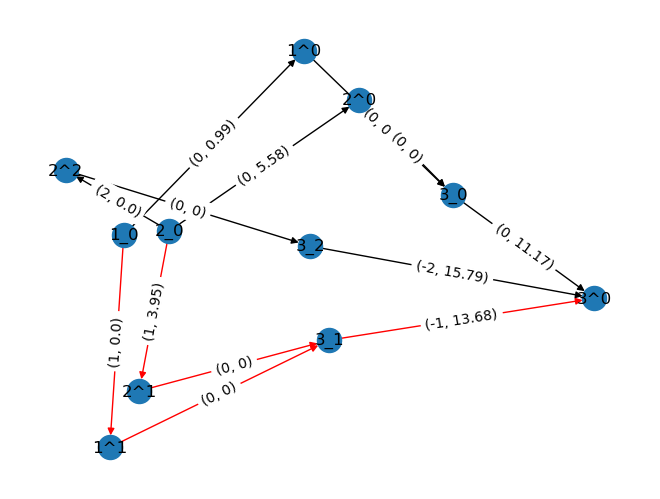

In [ ]:
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
# edge_colors = ['red' if edge in edgesUsed else 'black' 
#                for edge in dp_G.edges()]
# nx.draw(dp_G, pos, edge_color=edge_colors, with_labels=True)
# nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels)
# plt.show()